In [72]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as v2
from torchvision import models
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from torchmetrics import Accuracy
from torchmetrics.metric import Metric

In [73]:
# # https://drive.google.com/file/d/16QCd2dhOGNNDFxTFzLFmBG9SzP06A-y5/view
# !gdown 16QCd2dhOGNNDFxTFzLFmBG9SzP06A-y5
# !unzip ./data.zip

In [74]:
seed = 43
torch.random.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 16
num_epochs = 10
lr = 1e-5

root_path = "/home/stefan/ioai-prep/kits/roai-2025/angry-birds/data"

In [75]:
weights = models.ResNet50_Weights.IMAGENET1K_V1
resnet = models.resnet50(weights=weights).to(device)
resnet.fc = nn.Identity()
resnet.eval()
print("model loaded.")

model loaded.


# Data preparation

In [76]:
def remove_red_square(img: Image.Image) -> Image.Image:
    """
    detects and removes the red square by thresholding the red channel
    replaces with the mean of the surrounding border using OpenCV connected components
    """
    arr = np.array(img)
    # create binary mask: red channel max, others not max
    red_mask = (arr[..., 0] == 255) & (arr[..., 1] < 255) & (arr[..., 2] < 255)
    mask = red_mask.astype(np.uint8)  # 0 or 1

    # label connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    # iterate over components skipping background
    for lbl in range(1, num_labels):
        x, y, w, h, area = stats[lbl]
        # check for square within size bounds
        if 10 <= w <= 20 and 10 <= h <= 20 and abs(w - h) <= 1:
            # create inpainting mask for this component
            comp_mask = (labels == lbl).astype(np.uint8) * 255
            # dilate mask by 5 pixels to define border
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
            dilated = cv2.dilate(comp_mask, kernel)
            border = cv2.subtract(dilated, comp_mask)
            # compute mean color in border region
            border_pts = border.astype(bool)
            if np.any(border_pts):
                mean_color = arr[border_pts].reshape(-1, 3).mean(axis=0).astype(np.uint8)
                # fill the square region
                arr[comp_mask.astype(bool)] = mean_color
            break

    return Image.fromarray(arr)

In [77]:
def is_water_background(img: Image.Image, threshold: float = 1.1, pct: float = 0.05) -> bool:
    """
    simple heuristic: count fraction of pixels where B > threshold * G
    if fraction exceeds pct, classify as water background
    """
    arr = np.array(img)
    B = arr[..., 2].astype(float)
    G = arr[..., 1].astype(float)
    mask = B > threshold * (G + 1e-6)
    return mask.mean() >= pct

In [ ]:
class AngryBirdsDataset(Dataset):
  def __init__(self, split: str):
    super().__init__()

    self.split = split
    self.df = pd.read_csv(f"{root_path}/{split}.csv").reset_index(drop=True)  
    self.repetitions = 4

    self.orig_len = len(self.df)

    self.transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
    if split == 'train':
      self.transforms = v2.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        self.transforms
      ])

    self.precompute_bg_heuristic()
    print(f"{len(self.df)} from {self.orig_len}")

  def precompute_bg_heuristic(self):
    augmented = []
    augmented_bg_labels = []

    # precompute background labels and mark which images need red removal
    self.bg_labels = []  # 1 for water bg, 0 for land bg
    for idx, row in self.df.iterrows():
        img_path = os.path.join(root_path, self.split, row['filename'])
        img = Image.open(img_path).convert('RGB')

        is_water = is_water_background(img)
        self.bg_labels.append(int(is_water))

        if self.split == 'train':
            # Add repetitions for minority class
            if (is_water and row["y"] == 0) or (not is_water and row["y"] == 1):
                for _ in range(self.repetitions):
                    augmented.append(row.to_dict())
                    augmented_bg_labels.append(int(is_water))

    # add duplicates - data augmentation
    if augmented:
        df_augmented = pd.DataFrame(augmented, columns=self.df.columns)
        self.df = pd.concat([self.df, df_augmented], ignore_index=True)
        self.bg_labels.extend(augmented_bg_labels)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    # precompute the resnet activation feature
    # return only the (2048, ) features, without image
    dir = f"{root_path}/{self.split}"
    raw_filename = row['filename'][:len(".jpg")+1]
    if os.path.isfile(f"{dir}/{raw_filename}.npz"):
      with np.load(f"{dir}/{raw_filename}.npz") as archive:
        feats = archive["arr_0"]
      features = torch.from_numpy(feats)
    else:
      img = Image.open(f"{dir}/{row['filename']}")

      # prepare image
      if row.get('y', 0) == 0:
        img = remove_red_square(img)
      img = self.transforms(img)

      # save the activations in a numpy archive, saves storage
      with torch.no_grad():
        feats = resnet(img.unsqueeze(0).to(device))
      features = feats.cpu()
      np.savez(f"{dir}/{raw_filename}.npz", features.detach().cpu().numpy())

    if "y" in row:
      label = torch.tensor([row["y"]], dtype=torch.float32)
      bg_label = torch.tensor([self.bg_labels[idx]], dtype=torch.long)

      return features, label, bg_label

    return features

  def __len__(self):
    return len(self.df)

In [79]:
def make_balanced_sampler(dataset: AngryBirdsDataset) -> WeightedRandomSampler:
    # compute sample weights inverse to frequency of each (label, bg) combination
    counts = {}
    for _, row in dataset.df.iterrows():
        key = (int(row['y']), dataset.bg_labels[_])
        counts[key] = counts.get(key, 0) + 1

    weights = []
    for idx in range(len(dataset)):
        y = int(dataset.df.iloc[idx]['y'])
        bg = dataset.bg_labels[idx]
        weights.append(1.0 / counts[(y,bg)])

    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [80]:
train_dataset = AngryBirdsDataset("train")
train_sampler = make_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_dataset = AngryBirdsDataset("val")
val_loader = DataLoader(val_dataset, batch_size=batch_size)

21555 from 4795
1199 from 1199


In [81]:
batch = next(iter(train_loader))
batch[0], batch[1] = batch[0].to(device), batch[1].to(device)

[b.shape for b in batch]

[torch.Size([16, 1, 2048]), torch.Size([16, 1]), torch.Size([16, 1])]

# Model

In [82]:
class BirdsNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.head = nn.Sequential(
      nn.Dropout(0.4),
      nn.BatchNorm1d(1),
      nn.Linear(2048, 1),
    )

  def forward(self, x):
    # features = self.backbone(x)
    logits = self.head(x)
    return logits

In [83]:
model = BirdsNet().to(device)

model(batch[0]).shape

torch.Size([16, 1, 1])

# Training

In [84]:
# warming up
for loader in [train_loader, val_loader]:
  for _ in tqdm(loader):
    pass

100%|██████████| 75/75 [00:00<00:00, 238.08it/s]


In [85]:
losses = []

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs*len(train_loader), eta_min=1e-6)
scaler = GradScaler(device)

In [86]:
# prepare metrics - we want worst accuracy across the 4 labels
groups = [(y,bg) for y in [0,1] for bg in [0,1]]
cell_metrics = {g: Accuracy(task="binary").to(device) for g in groups}

In [87]:
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    total_samples = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]", unit="batch")
    for imgs, labels, _ in loop:
      imgs, labels = imgs.to(device), labels.to(device)

      # forward pass
      optimizer.zero_grad()
      with autocast(device):
        logits = model(imgs).squeeze(-1)
        loss = criterion(logits, labels)

      # backward pass
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      scheduler.step()

      # stats
      running_loss += loss.item() * imgs.size(0)
      total_samples += imgs.size(0)
      loop.set_postfix(loss=running_loss / total_samples)
      losses.append(loss.item())

    model.eval()
    val_loss = 0.0
    val_corrects, val_samples = 0, 0
    with torch.no_grad():
      for imgs, labels, bgs in tqdm(val_loader, desc="Validation"):
        imgs, labels, bgs = imgs.to(device), labels.to(device), bgs.to(device)

        with autocast(device):
          logits = model(imgs).squeeze(-1)
          val_loss += criterion(logits, labels).item() * imgs.size(0)
          preds = torch.sigmoid(logits)

        # update each cell metric
        for g, metric in cell_metrics.items():
          mask = (labels.long()==g[0]) & (bgs==g[1])
          if mask.any(): metric.update(preds[mask], labels[mask].long())

      val_loss /= len(val_dataset)
      # compute per-cell and worst
      cell_accs = {k: m.compute().item() for k, m in cell_metrics.items()}
      print(cell_accs)
      worst_acc = min(cell_accs.values())*100
      print(f"Validation Epoch {epoch}: loss={val_loss:.4f}, worst_cell_acc={worst_acc:.2f}%")

Validation: 100%|██████████| 75/75 [00:00<00:00, 118.07it/s]


{(0, 0): 0.8712643384933472, (0, 1): 0.5983935594558716, (1, 0): 0.6608695387840271, (1, 1): 0.8344370722770691}
Validation Epoch 1: loss=0.5355, worst_cell_acc=59.84%


Validation: 100%|██████████| 75/75 [00:00<00:00, 123.66it/s]


{(0, 0): 0.8712643384933472, (0, 1): 0.599397599697113, (1, 0): 0.656521737575531, (1, 1): 0.8344370722770691}
Validation Epoch 2: loss=0.5177, worst_cell_acc=59.94%


Validation: 100%|██████████| 75/75 [00:00<00:00, 119.92it/s]


{(0, 0): 0.8697317838668823, (0, 1): 0.5983935594558716, (1, 0): 0.6521739363670349, (1, 1): 0.8322295546531677}
Validation Epoch 3: loss=0.5305, worst_cell_acc=59.84%


Validation: 100%|██████████| 75/75 [00:00<00:00, 128.13it/s]


{(0, 0): 0.8695402145385742, (0, 1): 0.599397599697113, (1, 0): 0.6521739363670349, (1, 1): 0.8294702172279358}
Validation Epoch 4: loss=0.5388, worst_cell_acc=59.94%


Validation: 100%|██████████| 75/75 [00:00<00:00, 117.96it/s]


{(0, 0): 0.8694252967834473, (0, 1): 0.5991967916488647, (1, 0): 0.6521739363670349, (1, 1): 0.8278145790100098}
Validation Epoch 5: loss=0.5541, worst_cell_acc=59.92%


Validation: 100%|██████████| 75/75 [00:00<00:00, 116.77it/s]


{(0, 0): 0.8693486452102661, (0, 1): 0.5973895788192749, (1, 0): 0.6521739363670349, (1, 1): 0.8267108201980591}
Validation Epoch 6: loss=0.5640, worst_cell_acc=59.74%


Validation: 100%|██████████| 75/75 [00:00<00:00, 126.24it/s]


{(0, 0): 0.8692939281463623, (0, 1): 0.5966724157333374, (1, 0): 0.6521739363670349, (1, 1): 0.825922429561615}
Validation Epoch 7: loss=0.5658, worst_cell_acc=59.67%


Validation: 100%|██████████| 75/75 [00:00<00:00, 123.07it/s]


{(0, 0): 0.8692528605461121, (0, 1): 0.5963855385780334, (1, 0): 0.654347836971283, (1, 1): 0.8245033025741577}
Validation Epoch 8: loss=0.5645, worst_cell_acc=59.64%


Validation: 100%|██████████| 75/75 [00:00<00:00, 117.60it/s]


{(0, 0): 0.8692209720611572, (0, 1): 0.5959393382072449, (1, 0): 0.6570048332214355, (1, 1): 0.824135422706604}
Validation Epoch 9: loss=0.5736, worst_cell_acc=59.59%


Validation: 100%|██████████| 75/75 [00:00<00:00, 107.79it/s]

{(0, 0): 0.8689655065536499, (0, 1): 0.595381498336792, (1, 0): 0.6591304540634155, (1, 1): 0.8238410353660583}
Validation Epoch 10: loss=0.5780, worst_cell_acc=59.54%


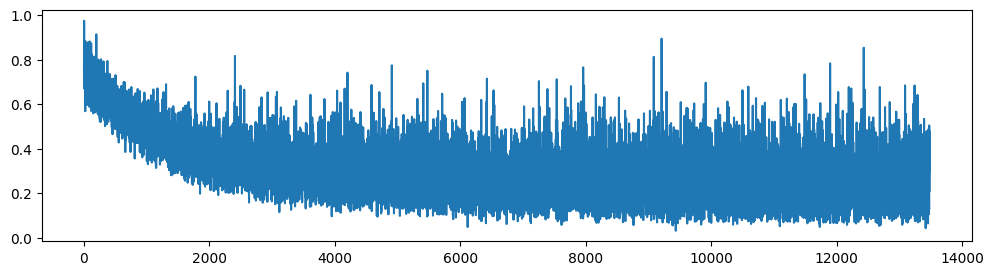

In [88]:
plt.figure(figsize=(12, 3))
plt.plot(losses)

# Submission

In [89]:
test_dataset = AngryBirdsDataset("test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

df_test = pd.read_csv(f"{root_path}/test.csv")

6993 from 6993


In [90]:
answer = []

model.eval()
for batch in tqdm(test_loader):
  batch = batch.to(device)
  with torch.no_grad():
    logits = model(batch).squeeze(-1)
  preds = (torch.sigmoid(logits) >= 0.5).detach().cpu().long().squeeze(-1)
  answer.extend(preds.tolist())

100%|██████████| 438/438 [00:01<00:00, 230.56it/s]


In [91]:
submission = pd.DataFrame({
    "datapointID": df_test["datapointID"],
    "subtaskID": 1,
    "answer": answer
})

submission.head()

,datapointID,subtaskID,answer
0,0,1,0
1,1,1,0
2,2,1,1
3,3,1,0
4,4,1,1


In [92]:
submission.to_csv("submission.csv", index=False)